In [1]:
import numpy as np
import polars as pl
import pandas as pd
import catboost as cbt
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import gc
import warnings

# Настройки
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [2]:
class Config:
    target = "responder_6"
    features = [f"feature_{i:02d}" for i in range(79)] 
    lags = [f"responder_{i}_lag_1" for i in range(9)]
    cat_features = ["symbol_id"]
    val_size = 0.1
    n_splits = 2  # Можно уменьшить до 1 для максимальной экономии памяти

def load_data():
    """Оптимизированная загрузка данных"""
    columns = Config.features + Config.lags + Config.cat_features + [Config.target, "weight"]
    return (
        pl.scan_parquet("/kaggle/input/js24-preprocessing-catboost/training.parquet/")
        .select(columns)
    )

def prepare_features(data):
    """Подготовка фичей с контролем памяти"""
    df = data.collect(streaming=True)
    # Переводим все фичи в float32 для экономии памяти
    X = df[Config.features + Config.lags + Config.cat_features].to_pandas()
    X = X.astype({col: np.float32 for col in Config.features + Config.lags})
    y = df[Config.target].to_numpy().astype(np.float32)
    weights = df["weight"].to_numpy().astype(np.float32)

    del df
    gc.collect()
    for col in X.columns:
        if X[col].isnull().any():
            X[col].fillna(X[col].mean(), inplace=True)
    cat_col_idx = [X.columns.get_loc(col) for col in Config.cat_features]
    X[Config.cat_features] = X[Config.cat_features].astype('category')
    return X, y, weights, cat_col_idx

def weighted_r2(y_true, y_pred, weights):
    """Эффективная реализация взвешенной R2"""
    weights = np.ones_like(y_true) if weights is None else weights
    y_mean = np.average(y_true, weights=weights)
    numerator = np.sum(weights * (y_true - y_pred)**2)
    denominator = np.sum(weights * (y_true - y_mean)**2)
    return 1 - numerator / (denominator + 1e-10)


=== Training LightGBM ===

LightGBM Fold 1/3


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 10 rounds
[20]	valid_0's rmse: 0.752181	valid_0's l2: 0.565777
Early stopping, best iteration is:
[21]	valid_0's rmse: 0.752148	valid_0's l2: 0.565727
LightGBM Fold 1 R2: 0.0015

LightGBM Fold 2/3
Training until validation scores don't improve for 10 rounds
[20]	valid_0's rmse: 0.825719	valid_0's l2: 0.681813
[40]	valid_0's rmse: 0.825367	valid_0's l2: 0.681231
[60]	valid_0's rmse: 0.825205	valid_0's l2: 0.680963
[80]	valid_0's rmse: 0.825044	valid_0's l2: 0.680697
[100]	valid_0's rmse: 0.824994	valid_0's l2: 0.680616
Early stopping, best iteration is:
[92]	valid_0's rmse: 0.824982	valid_0's l2: 0.680595
LightGBM Fold 2 R2: 0.0036

LightGBM Fold 3/3
Training until validation scores don't improve for 10 rounds
[20]	valid_0's rmse: 0.76435	valid_0's l2: 0.584231
[40]	valid_0's rmse: 0.763906	valid_0's l2: 0.583553
[60]	valid_0's rmse: 0.763728	valid_0's l2: 0.58328
[80]	valid_0's rmse: 0.763598	valid_0's l2: 0.583082
[100]	valid_0's rmse

Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0013427	test: 0.0001647	best: 0.0001647 (0)	total: 340ms	remaining: 1m 7s
bestTest = 0.002301117702
bestIteration = 28
Shrink model to first 29 iterations.
CatBoost Fold 1 R2: 0.0023

CatBoost Fold 2/3


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0008309	test: 0.0002177	best: 0.0002177 (0)	total: 301ms	remaining: 59.9s
100:	learn: 0.0423612	test: 0.0038415	best: 0.0038547 (90)	total: 21.2s	remaining: 20.7s
bestTest = 0.003854705898
bestIteration = 90
Shrink model to first 91 iterations.
CatBoost Fold 2 R2: 0.0038

CatBoost Fold 3/3


Default metric period is 5 because R2 is/are not implemented for GPU
Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.0005865	test: 0.0002519	best: 0.0002519 (0)	total: 549ms	remaining: 1m 49s
100:	learn: 0.0253046	test: 0.0051280	best: 0.0051285 (99)	total: 30s	remaining: 29.4s
bestTest = 0.005460122738
bestIteration = 171
Shrink model to first 172 iterations.
CatBoost Fold 3 R2: 0.0049

=== Training XGBoost ===

XGBoost Fold 1/3
[0]	validation_0-rmse:0.77928	validation_1-rmse:0.75262
[44]	validation_0-rmse:0.77028	validation_1-rmse:0.75200
XGBoost Fold 1 R2: 0.0020


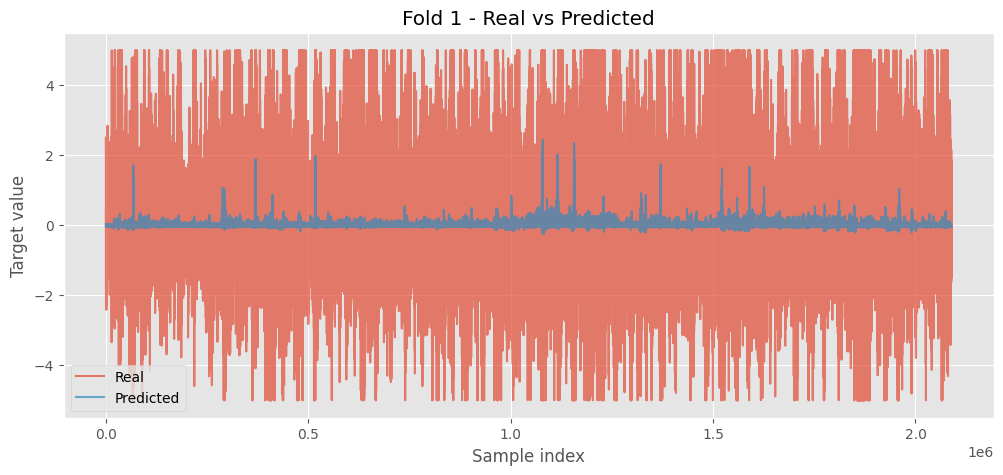


XGBoost Fold 2/3
[0]	validation_0-rmse:0.76798	validation_1-rmse:0.82645
[97]	validation_0-rmse:0.75879	validation_1-rmse:0.82491
XGBoost Fold 2 R2: 0.0038


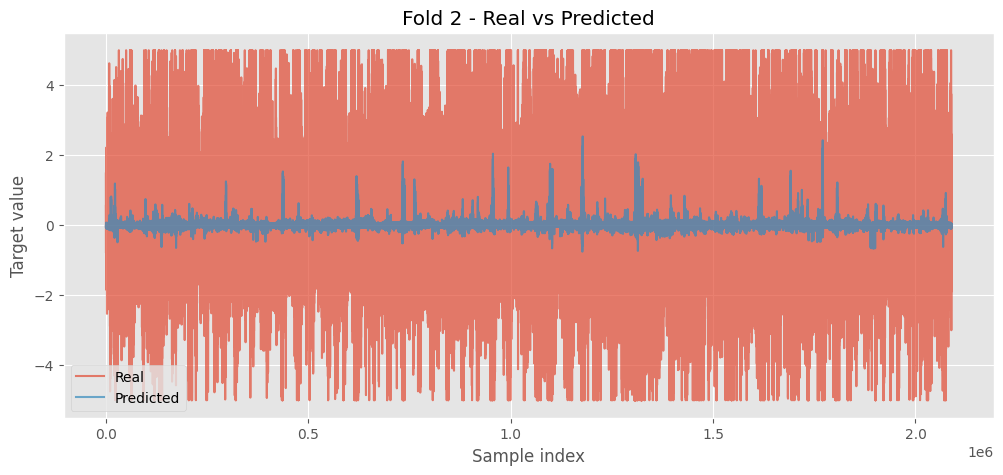


XGBoost Fold 3/3
[0]	validation_0-rmse:0.78838	validation_1-rmse:0.76511
[100]	validation_0-rmse:0.78201	validation_1-rmse:0.76357
[144]	validation_0-rmse:0.78021	validation_1-rmse:0.76348
XGBoost Fold 3 R2: 0.0044


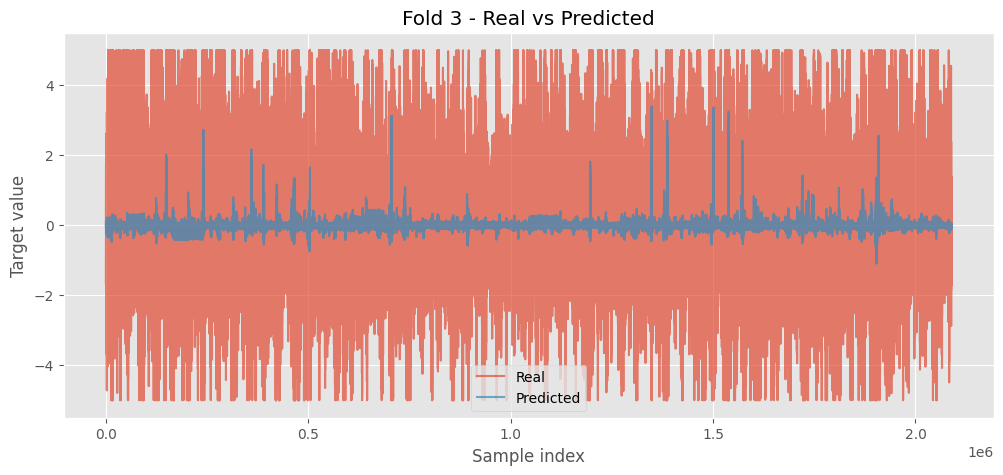

In [3]:
def train_xgboost(X, y, weights, n_splits=3):
    """Обучение XGBoost с визуализацией реальных и предсказанных значений на каждом фолде"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []

    cat_col = Config.cat_features[0]
    X_encoded = pd.get_dummies(X, columns=[cat_col], dtype=np.float32)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_encoded), 1):
        print(f"\nXGBoost Fold {fold}/{n_splits}")

        X_train, X_val = X_encoded.iloc[train_idx], X_encoded.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        w_train, w_val = weights[train_idx], weights[val_idx]

        X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)

        model = xgb.XGBRegressor(
            objective='reg:squarederror',
            learning_rate=0.05,
            n_estimators=200,
            max_depth=3,
            subsample=0.5,
            colsample_bytree=0.5,
            min_child_weight=10,
            tree_method='gpu_hist',
            predictor='gpu_predictor',
            eval_metric='rmse',
            n_jobs=1
        )

        model.fit(
            X_train, y_train,
            sample_weight=w_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            sample_weight_eval_set=[w_train, w_val],
            verbose=100,
            early_stopping_rounds=10
        )

        y_pred = model.predict(X_val)
        score = weighted_r2(y_val, y_pred, w_val)
        results.append(score)
        print(f"XGBoost Fold {fold} R2: {score:.4f}")

        # Визуализация реальных и предсказанных значений
        plt.figure(figsize=(12, 5))
        plt.plot(y_val, label='Real', alpha=0.7)
        plt.plot(y_pred, label='Predicted', alpha=0.7)
        plt.title(f'Fold {fold} - Real vs Predicted')
        plt.xlabel('Sample index')
        plt.ylabel('Target value')
        plt.legend()
        plt.grid(True)
        plt.show()

        del model, X_train, X_val, y_train, y_val, w_train, w_val
        gc.collect()

    del X_encoded
    gc.collect()
    return results

def train_lightgbm(X, y, weights, cat_col_idx, n_splits=3):
    """Обучение LightGBM"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        print(f"\nLightGBM Fold {fold}/{n_splits}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        w_train, w_val = weights[train_idx], weights[val_idx]
        # Используем float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        model = lgb.LGBMRegressor(
            objective="regression",
            n_estimators=200,      # Меньше деревьев
            learning_rate=0.05,
            max_depth=3,
            num_leaves=15,
            min_child_samples=50,
            subsample=0.5,
            colsample_bytree=0.5,
            device='gpu',
            verbose=-1
        )
        model.fit(
            X_train, y_train,
            sample_weight=w_train,
            eval_set=[(X_val, y_val)],
            eval_sample_weight=[w_val],
            eval_metric='rmse',
            categorical_feature=cat_col_idx,
            callbacks=[lgb.early_stopping(10), lgb.log_evaluation(20)]
        )
        score = weighted_r2(y_val, model.predict(X_val), w_val)
        results.append(score)
        print(f"LightGBM Fold {fold} R2: {score:.4f}")
        del model, X_train, X_val, y_train, y_val, w_train, w_val
        gc.collect()
    return results

def train_catboost(X, y, weights, cat_col_idx, n_splits=3):
    """Обучение CatBoost"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = []
    
    # Преобразование категориального признака
    X_cb = X.copy()
    cat_col = X.columns[cat_col_idx[0]]  
    X_cb[cat_col] = X_cb[cat_col].astype(int).astype(str)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_cb), 1):
        print(f"\nCatBoost Fold {fold}/{n_splits}")
        
        X_train, X_val = X_cb.iloc[train_idx], X_cb.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        w_train, w_val = weights[train_idx], weights[val_idx]
        
        model = cbt.CatBoostRegressor(
            iterations=200,
            learning_rate=0.05,
            loss_function='RMSE',
            eval_metric='R2',
            early_stopping_rounds=20,
            cat_features=cat_col_idx,
            task_type='GPU',
            verbose=100
        )
        
        model.fit(
            X_train, y_train,
            sample_weight=w_train,
            eval_set=(X_val, y_val)
        )
        
        score = weighted_r2(y_val, model.predict(X_val), w_val)
        results.append(score)
        print(f"CatBoost Fold {fold} R2: {score:.4f}")
        
        del model, X_train, X_val, y_train, y_val, w_train, w_val
        gc.collect()
    
    return results



"""Сравнение моделей"""
# print("Loading data...")
data = load_data()
X, y, weights, cat_col_idx = prepare_features(data)
del data
gc.collect()
print("\n=== Training LightGBM ===")
lgb_results = train_lightgbm(X, y, weights, cat_col_idx, n_splits=3)
print("\n=== Training CatBoost ===")
cb_results = train_catboost(X, y, weights, cat_col_idx, n_splits=3)
print("\n=== Training XGBoost ===")
xgb_results = train_xgboost(X, y, weights)

results = {
    "XGBoost": xgb_results,
    "LightGBM": lgb_results,
    "CatBoost": cb_results
}


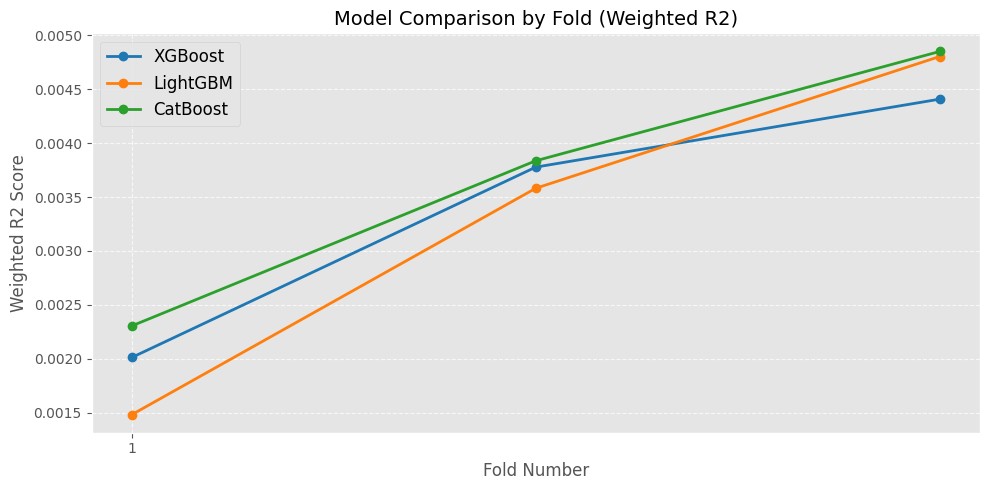


=== Final Results ===
XGBoost:
  Mean R2: 0.0034
  Std R2: 0.0010
  Fold scores: [0.002, 0.0038, 0.0044]
LightGBM:
  Mean R2: 0.0033
  Std R2: 0.0014
  Fold scores: [0.0015, 0.0036, 0.0048]
CatBoost:
  Mean R2: 0.0037
  Std R2: 0.0010
  Fold scores: [0.0023, 0.0038, 0.0049]

Recommendation: Use CatBoost as baseline (highest mean R2: 0.0037)


In [4]:
plt.figure(figsize=(10, 5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for (model, scores), color in zip(results.items(), colors):
    plt.plot(range(1, len(scores)+1), scores, 
            label=model, marker='o', linewidth=2, color=color)
plt.title("Model Comparison by Fold (Weighted R2)", fontsize=14)
plt.xlabel("Fold Number", fontsize=12)
plt.ylabel("Weighted R2 Score", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, 2))
plt.tight_layout()
plt.show()
print("\n=== Final Results ===")
final_scores = {}
for model, scores in results.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    final_scores[model] = mean_score
    print(f"{model}:")
    print(f"  Mean R2: {mean_score:.4f}")
    print(f"  Std R2: {std_score:.4f}")
    print(f"  Fold scores: {[round(s, 4) for s in scores]}")
best_model = max(final_scores.items(), key=lambda x: x[1])
print(f"\nRecommendation: Use {best_model[0]} as baseline (highest mean R2: {best_model[1]:.4f})")